# Importing libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import SGD, Adam, lr_scheduler
from copy import deepcopy
from utils import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_generator = torch.manual_seed(0)

In [3]:
classes_names = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
train_loader, val_loader, test_loader = load_data(train_transform, test_transform, random_generator)

Files already downloaded and verified
Files already downloaded and verified


# Exploring dataset

In [5]:
data_iterator = iter(train_loader)
images, classes = data_iterator.next()

In [6]:
images[0].shape

torch.Size([3, 32, 32])

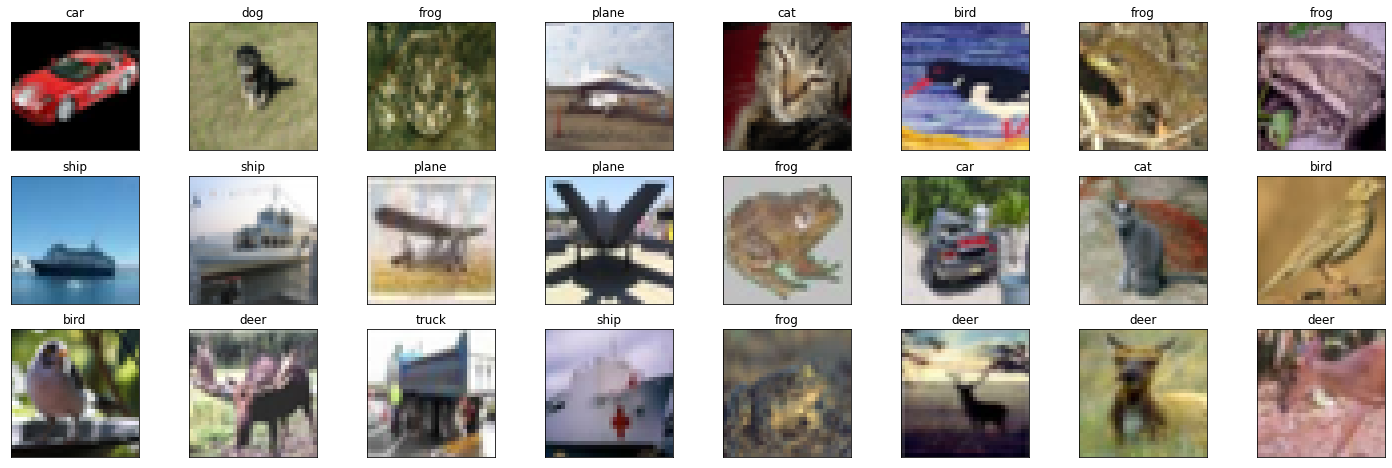

In [7]:
fig = plt.figure(figsize=(25, 8))

def show_image(image):
    image = image / 2 + 0.5
    image = image.numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))

n_row = 3
batch_size = 8

for row_idx in np.arange(n_row):
    images, classes = data_iterator.next()
    for idx in np.arange(batch_size):
      ax = fig.add_subplot(n_row, batch_size, batch_size*row_idx+idx+1, xticks=[], yticks=[])
      show_image(images[idx])
      ax.set_title(classes_names[classes[idx]])

# Simple CNN model with SGD optimizer

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        self.fc1 = nn.Linear(9 * 6 * 6, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
model = SimpleCNN().to(device)
# optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
train_network(model, train_loader, val_loader, epochs = 30)

Epoch 1
Training loss: 2.298915664630466
Training accuracy: 10.166666666666666%
Validation accuracy: 11.68%
------------------------------
Epoch 2
Training loss: 2.213423725001017
Training accuracy: 18.115555555555556%
Validation accuracy: 24.82%
------------------------------
Epoch 3
Training loss: 1.9801514285405477
Training accuracy: 29.466666666666665%
Validation accuracy: 32.96%
------------------------------
Epoch 4
Training loss: 1.8203879960801865
Training accuracy: 34.22666666666667%
Validation accuracy: 35.16%
------------------------------
Epoch 5
Training loss: 1.717323379113939
Training accuracy: 37.8%
Validation accuracy: 38.98%
------------------------------
Epoch 6
Training loss: 1.6414509217156303
Training accuracy: 40.45111111111111%
Validation accuracy: 41.52%
------------------------------
Epoch 7
Training loss: 1.5838102098253037
Training accuracy: 42.586666666666666%
Validation accuracy: 42.48%
------------------------------
Epoch 8
Training loss: 1.53565051087273

In [11]:
evaluate_network(model, test_loader)

Test accuracy: 58.61%


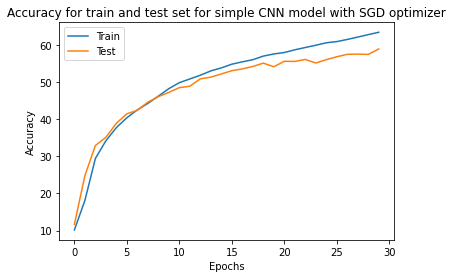

In [12]:
plt.figure()
plt.plot([i for i in range(model.epochs)], model.train_accuracy)
plt.plot([i for i in range(model.epochs)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title('Accuracy for train and test set for simple CNN model with SGD optimizer')
plt.show()

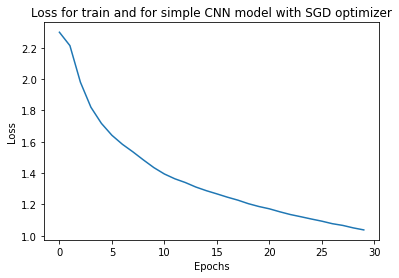

In [13]:
plt.figure()
plt.plot([i for i in range(model.epochs)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with SGD optimizer')
plt.show()

# Simple CNN model with Adam optimizer

In [14]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [15]:
train_network(model, train_loader, val_loader, optimizer = optimizer, epochs = 30)

Epoch 1
Training loss: 1.8222412715911864
Training accuracy: 32.906666666666666%
Validation accuracy: 40.94%
------------------------------
Epoch 2
Training loss: 1.5132204008314345
Training accuracy: 45.022222222222226%
Validation accuracy: 47.04%
------------------------------
Epoch 3
Training loss: 1.406676778793335
Training accuracy: 49.20666666666666%
Validation accuracy: 48.78%
------------------------------
Epoch 4
Training loss: 1.3352511580785116
Training accuracy: 51.84444444444444%
Validation accuracy: 50.6%
------------------------------
Epoch 5
Training loss: 1.2840691635979546
Training accuracy: 53.846666666666664%
Validation accuracy: 52.26%
------------------------------
Epoch 6
Training loss: 1.239154855049981
Training accuracy: 55.42%
Validation accuracy: 53.1%
------------------------------
Epoch 7
Training loss: 1.204689354663425
Training accuracy: 56.9%
Validation accuracy: 54.14%
------------------------------
Epoch 8
Training loss: 1.1735440388997396
Training acc

In [16]:
evaluate_network(model, test_loader)

Test accuracy: 58.19%


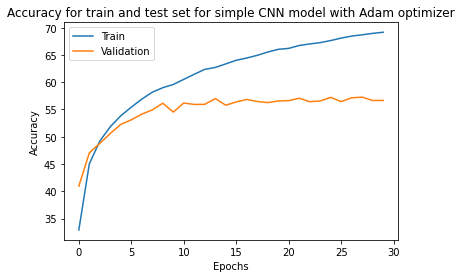

In [17]:
plt.figure()
plt.plot([i for i in range(model.epochs)], model.train_accuracy)
plt.plot([i for i in range(model.epochs)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy for train and test set for simple CNN model with Adam optimizer')
plt.show()

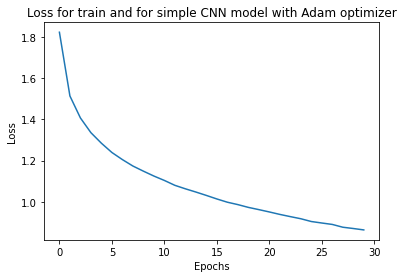

In [18]:
plt.figure()
plt.plot([i for i in range(model.epochs)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with Adam optimizer')
plt.show()

# Simple CNN model with Adam optimizer and simple data augmentation

In [25]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
train_network(model, train_loader, val_loader, optimizer = optimizer, epochs = 30)

Epoch 1
Training loss: 1.7631898926205105
Training accuracy: 35.593333333333334%
Validation accuracy: 44.0%
------------------------------
Epoch 2
Training loss: 1.4861381878958808
Training accuracy: 45.99777777777778%
Validation accuracy: 45.96%
------------------------------
Epoch 3
Training loss: 1.3887619281344943
Training accuracy: 49.67777777777778%
Validation accuracy: 49.84%
------------------------------
Epoch 4
Training loss: 1.3166053439670138
Training accuracy: 52.666666666666664%
Validation accuracy: 51.54%
------------------------------
Epoch 5
Training loss: 1.2617246074464585
Training accuracy: 54.791111111111114%
Validation accuracy: 51.48%
------------------------------
Epoch 6
Training loss: 1.2189581156200833
Training accuracy: 56.33777777777778%
Validation accuracy: 54.22%
------------------------------
Epoch 7
Training loss: 1.1783166809505887
Training accuracy: 58.02444444444444%
Validation accuracy: 54.46%
------------------------------
Epoch 8
Training loss: 1.

In [26]:
evaluate_network(model, test_loader)

Test accuracy: 58.63%


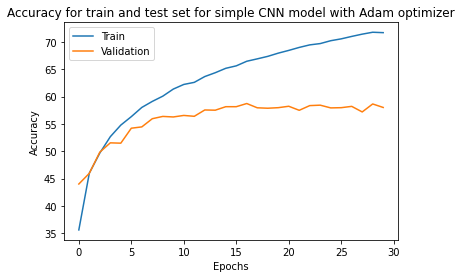

In [27]:
plt.figure()
plt.plot([i for i in range(model.epochs)], model.train_accuracy)
plt.plot([i for i in range(model.epochs)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy for train and test set for simple CNN model with Adam optimizer')
plt.show()

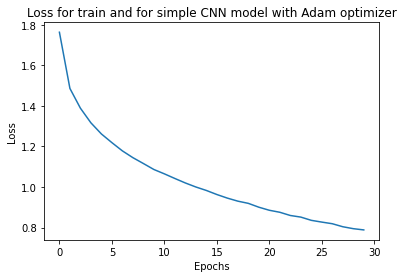

In [28]:
plt.figure()
plt.plot([i for i in range(model.epochs)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with Adam optimizer')
plt.show()